In [51]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS

In [52]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [53]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [54]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [55]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data.sample(5)

794


,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year
192801,218992,68901105,2017,m_5th_avescore,1603.0,0.100595,CAMERON DUAL LANGUAGE MAGNET,N,68901,ECTOR COUNTY ISD,...,-1.0,0,0,0,0,1,0,0,0,m_5th_avescore2017
134697,160816,20901105,2014,r_5th_avescore,1578.0,0.381736,E C MASON ELEMENTARY,N,20901,ALVIN ISD,...,-3.0,0,0,1,0,0,0,0,0,r_5th_avescore2014
110791,136857,15910108,2012,m_5th_avescore,1532.0,-0.956375,LARKSPUR EL,N,15910,NORTH EAST ISD,...,-6.0,1,0,0,0,0,0,0,0,m_5th_avescore2012
41338,50704,101919047,2015,m_7th_avescore,1578.0,-0.907304,STELLE CLAUGHTON MIDDLE,N,101919,SPRING ISD,...,-3.0,0,0,1,0,0,0,0,0,m_7th_avescore2015
150393,176529,246909105,2014,m_3rd_avescore,1592.0,2.381065,SPICEWOOD EL,N,246909,ROUND ROCK ISD,...,-3.0,0,0,1,0,0,0,0,0,m_3rd_avescore2014


# Create HTE Variables

In [56]:
data_pre = data.loc[data.pre1 == 1]
data_pre['avescores_pre'] = data_pre.groupby('campus')['score_std'].transform('mean')
data_pre = data_pre.drop_duplicates(subset = 'campus')
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teachers_turnover_pre',
                                     'students_ell': 'students_ell_pre',
                                      'students_white': 'students_white_pre',
                                      'students_black': 'students_black_pre',
                                     'students_sped': 'students_sped_pre',
                                     'score_std': 'score_std_pre',
                                    'students_num': 'students_num_pre'})
for var in ['students_hisp_pre', 'students_ell_pre', 'students_white_pre', 'students_black_pre',
            'students_num_pre', 'teachers_turnover_pre', 'avescores_pre']:
    for p in [.25, .5, .75, 1]:
        num = str(int(p * 100))
        newvar = var + num
        if p == .25:
            data_pre[newvar] = np.where(data_pre[var] <= data_pre[var].quantile(p), 1, 0)
        if p > .25:
            lp = p - .25
            data_pre[newvar] = np.where(((data_pre[var] > data_pre[var].quantile(lp)) &
                                         (data_pre[var] <= data_pre[var].quantile(p))), 1, 0)
variables = ['campus']
variables = variables + (list(data_pre.filter(regex = ("_pre"))))
data_pre = data_pre[variables]
data_pre = data_pre.merge(data[data.year == 2016][['campus', 'type_urban', 'type_suburban', 'type_town', 'type_rural']], 
                          how = 'left', left_on = ['campus'], right_on = ['campus'])
data_pre = data_pre.rename(columns = {'type_urban': 'type_urban_pre',
                                      'type_suburban': 'type_suburban_pre',
                                      'type_town': 'type_town_pre',
                                      'type_rural': 'type_rural_pre'})
data_pre['teachers_turnover_pre'] = data_pre.teachers_turnover_pre / 100
data_pre.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,campus,score_std_pre,students_num_pre,teachers_turnover_pre,students_black_pre,students_hisp_pre,students_white_pre,students_ell_pre,students_sped_pre,avescores_pre,...,teachers_turnover_pre75,teachers_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100,type_urban_pre,type_suburban_pre,type_town_pre,type_rural_pre
29849,221901112,0.384395,538,0.157,0.092937,0.343866,0.485130,0.044610,0.105948,0.407887,...,0,0,0,0,1,0,1.0,0.0,0.0,0.0
22115,61902105,-1.186755,614,0.125,0.043974,0.622150,0.076547,0.742671,0.105863,-1.473854,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
28409,43907109,1.530025,477,0.136,0.029350,0.167715,0.721174,0.014675,0.113208,2.020180,...,0,0,0,0,0,1,0.0,1.0,0.0,0.0
9766,220906007,0.435017,484,0.161,0.037190,0.132231,0.704545,0.000000,0.014463,1.319067,...,1,0,0,0,0,1,0.0,1.0,0.0,0.0
26900,225906101,0.875379,465,0.126,0.040860,0.367742,0.556989,0.236559,0.094624,0.628412,...,0,0,0,0,1,0,0.0,0.0,1.0,0.0


In [57]:
data_pre.teachers_turnover_pre.max()

0.63

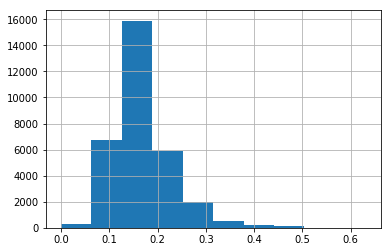

In [58]:
data_pre.teachers_turnover_pre.hist()

Text(0.04,0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

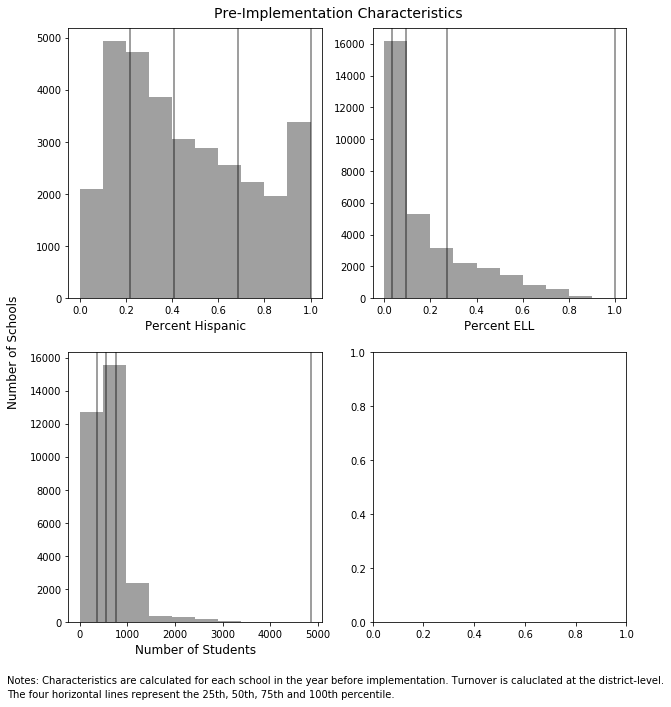

In [59]:
fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]


bins = 10

ax1.hist(data_pre.students_hisp_pre, bins, facecolor='gray', alpha=0.75)
ax1.set_xlabel('Percent Hispanic', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax1.axvline(data_pre.students_hisp_pre.quantile(p), color = 'black', alpha = 0.5 )


ax2.hist(data_pre.students_ell_pre, bins, facecolor='gray', alpha=0.75)
ax2.set_xlabel('Percent ELL', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax2.axvline(data_pre.students_ell_pre.quantile(p), color = 'black', alpha = 0.5 )

ax3.hist(data_pre.students_num_pre,  bins, facecolor='gray', alpha=0.75)
ax3.set_xlabel('Number of Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax3.axvline(data_pre.students_num_pre.quantile(p), color = 'black', alpha = 0.5 )


# ax4.hist(data_pre.teachers_turnover_pre,  bins, facecolor='gray', alpha=0.75)
# ax4.set_xlabel('Percent Turnover', fontsize = 12)
# for p in [.25, .5, .75, 1]:
#     ax4.axvline(data_pre.teachers_turnover_pre.quantile(p), color = 'black', alpha = 0.5 )


fig.text(0.04, 0.5, 'Number of Schools', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Pre-Implementation Characteristics', fontsize = 14)
fig.subplots_adjust(top=0.95)
fig.savefig(table_path + 'Pre-Implementation Characteristics.png')

fig.text(0.04, 0.04, 'Notes: Characteristics are calculated for each school in the year before implementation.'
        ' Turnover is caluclated at the district-level.')
fig.text(0.04, 0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

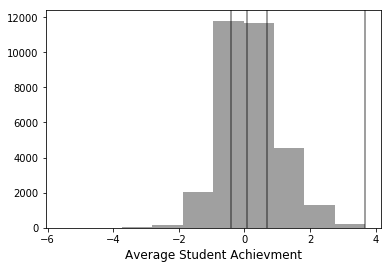

In [60]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.avescores_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Average Student Achievment', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.avescores_pre.quantile(p), color = 'black', alpha = 0.5 )

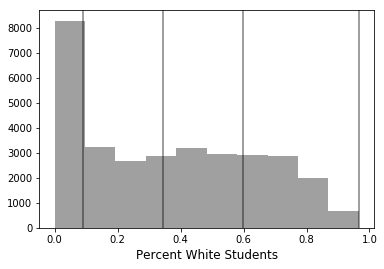

In [61]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.students_white_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent White Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.students_white_pre.quantile(p), color = 'black', alpha = 0.5 )

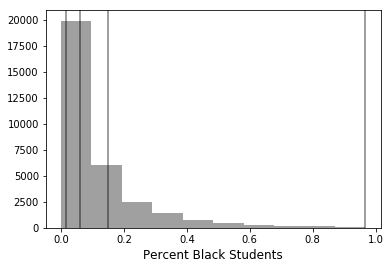

In [62]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.students_black_pre, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent Black Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.students_black_pre.quantile(p), color = 'black', alpha = 0.5 )

In [63]:
data = data.reset_index()
data_pre = data_pre.reset_index()

In [64]:
data = data.reset_index().set_index(['campus', 'test'])
data_pre = data_pre.reset_index().set_index(['campus'])
data.head()

level_0  index  Unnamed: 0  year   score  score_std  \
campus    test                                                                  
109901001 alg_avescore          0      0           0  2012  4069.0  -0.002635   
          bio_avescore          1      1           1  2012  3852.0  -0.712471   
          eng1_avescore         2      2           2  2012  4076.0   0.501276   
          m_3rd_avescore        3      3           3  2012  1463.0   0.269832   
          m_4th_avescore        4      4           4  2012  1494.0  -0.590598   

                               campname campischarter  district    distname  \
campus    test                                                                
109901001 alg_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          bio_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          eng1_avescore   ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_3rd_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_4th_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   

                          ... yearpre pre5 pre4 pre3 pre2 pre1 post1  post2  \
campus    test            ...                                                 
109901001 alg_avescore    ...    -6.0    1    0    0    0    0     0      0   
          bio_avescore    ...    -6.0    1    0    0    0    0     0      0   
          eng1_avescore   ...    -6.0    1    0    0    0    0     0      0   
          m_3rd_avescore  ...    -6.0    1    0    0    0    0     0      0   
          m_4th_avescore  ...    -6.0    1    0    0    0    0     0      0   

                          post3        test_by_year  
campus    test                                       
109901001 alg_avescore        0    alg_avescore2012  
          bio_avescore        0    bio_avescore2012  
          eng1_avescore       0   eng1_avescore2012  
          m_3rd_avescore      0  m_3rd_avescore2012  
          m_4th_avescore      0  m_4th_avescore2012  

[5 rows x 173 columns]

In [65]:
data_hte = data.reset_index().merge(data_pre, left_on = 'campus', right_on = 'campus', how = 'left')
data_hte.head(5)

,campus,test,level_0_x,index_x,Unnamed: 0,year,score,score_std,campname,campischarter,...,teachers_turnover_pre75,teachers_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100,type_urban_pre,type_suburban_pre,type_town_pre,type_rural_pre
0,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,109901001,alg_avescore,0,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [66]:
#convert year to datetime
data_hte['year'] = pd.to_datetime(data_hte['year'], format='%Y')
#add column year to index
data_hte = data_hte.set_index(['year', 'campus'])
#swap indexes
data_hte.index = data_hte.index.swaplevel(0,1)
data_hte[['district', 'doi_year','treatpost', 'students_hisp_pre',]].sample(5)

,,district,doi_year,treatpost,students_hisp_pre
campus,year,,,,
101921105,2012-01-01,101921,2018.0,False,0.312588
70912107,2014-01-01,70912,2018.0,False,0.325696
39904001,2018-01-01,39904,2018.0,True,0.072464
43914044,2015-01-01,43914,2017.0,False,0.176871
68901046,2016-01-01,68901,2018.0,False,0.518095


# Hispanic

In [67]:
# Get table ready
file = table_path + 'table4_gdid_and_event_hte.xlsx'
wb = load_workbook(file)
ws = wb.active

In [68]:
gdid_model = 'score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects'
linear_gdid_model = 'score_std ~ + 1 + treatpost + yearpost + yearpre  + C(test_by_year) + EntityEffects'
event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3  + C(test_by_year) + EntityEffects'

In [69]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_hisp' + str(p)
    var = 'students_hisp_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula(gdid_model + '  + treatpost_hisp50 + treatpost_hisp75 + treatpost_hisp100', data_hte)
res = mod.fit(cov_type='clustered', clusters = data_hte.district)
row = 3
for var in ['treatpost[T.True]', 'treatpost_hisp50', 'treatpost_hisp75', 'treatpost_hisp100']:
    ws.cell(row= row, column= 2).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 2).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1901
Estimator:                   PanelOLS   R-squared (Between):             -0.2250
No. Observations:             1616825   R-squared (Within):               0.1901
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.0118
Time:                        10:06:33   Log-likelihood                -1.314e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3074.0
Entities:                        5639   P-value                           0.0000
Avg Obs:                       286.72   Distribution:             F(123,1611063)
Min Obs:                       1.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             255.15
                            

# Black

In [70]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_black' + str(p)
    var = 'students_black_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_black + students_hisp + students_num + C(test_by_year) + EntityEffects' 
     + '  + treatpost_black50 + treatpost_black75 + treatpost_black100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
row = 3
for var in ['treatpost[T.True]', 'treatpost_black50', 'treatpost_black75', 'treatpost_black100']:
    ws.cell(row= row, column= 3).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 3).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1930
Estimator:                   PanelOLS   R-squared (Between):              0.0733
No. Observations:             1616825   R-squared (Within):               0.1930
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.1880
Time:                        10:14:01   Log-likelihood                -1.311e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3057.2
Entities:                        5639   P-value                           0.0000
Avg Obs:                       286.72   Distribution:             F(126,1611060)
Min Obs:                       1.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             247.31
                            

# ELL

In [71]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_ell' + str(p)
    var = 'students_ell_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_ell + students_num + C(test_by_year) + EntityEffects' 
     + '  + treatpost_ell50 + treatpost_ell75 + treatpost_ell100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
row = 3
for var in ['treatpost[T.True]', 'treatpost_ell50', 'treatpost_ell75', 'treatpost_ell100']:
    ws.cell(row= row, column= 4).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1907
Estimator:                   PanelOLS   R-squared (Between):             -0.1903
No. Observations:             1616825   R-squared (Within):               0.1907
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.0463
Time:                        10:19:29   Log-likelihood                -1.313e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3037.2
Entities:                        5639   P-value                           0.0000
Avg Obs:                       286.72   Distribution:             F(125,1611061)
Min Obs:                       1.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             250.66
                            

# Turnover

In [72]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_turnover' + str(p)
    var = 'teachers_turnover_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_num + C(test_by_year) + EntityEffects' 
     + '  + treatpost_turnover50 + treatpost_turnover75 + treatpost_turnover100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
row = 3
for var in ['treatpost[T.True]', 'treatpost_turnover50', 'treatpost_turnover75', 'treatpost_turnover100']:
    ws.cell(row= row, column= 5).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 5).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1899
Estimator:                   PanelOLS   R-squared (Between):             -0.2055
No. Observations:             1616825   R-squared (Within):               0.1899
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.0193
Time:                        10:26:21   Log-likelihood                -1.314e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3046.0
Entities:                        5639   P-value                           0.0000
Avg Obs:                       286.72   Distribution:             F(124,1611062)
Min Obs:                       1.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             252.18
                            

In [73]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_score' + str(p)
    var = 'avescores_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects' 
     + '  + treatpost_score50 + treatpost_score75 + treatpost_score100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
row = 3
for var in ['treatpost[T.True]', 'treatpost_score50', 'treatpost_score75', 'treatpost_score100']:
    ws.cell(row= row, column= 6).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 6).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1895
Estimator:                   PanelOLS   R-squared (Between):             -0.1908
No. Observations:             1616825   R-squared (Within):               0.1895
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.0333
Time:                        10:32:17   Log-likelihood                -1.314e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3061.9
Entities:                        5639   P-value                           0.0000
Avg Obs:                       286.72   Distribution:             F(123,1611063)
Min Obs:                       1.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             256.59
                            

# Urbanicity

In [74]:
formula_vars = ''
for disttype in ['urban', 'suburban', 'town', 'rural']:
    newvar = 'treatpost_' + disttype
    var = 'type_' + disttype + '_pre'
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects' 
     + '  + treatpost_town + treatpost_suburban + treatpost_urban'
     + '  + type_town + type_suburban + type_urban', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
row = 3
for var in ['treatpost[T.True]', 'treatpost_town', 'treatpost_suburban', 'treatpost_urban']:
    ws.cell(row= row, column= 7).value = bonferroni(6, res.params[var], res.pvalues[var])
    row = row + 1
    ws.cell(row= row, column= 7).value = format_se(res.std_errors[var])
    row = row + 1
wb.save(file)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1888
Estimator:                   PanelOLS   R-squared (Between):             -0.2357
No. Observations:             1616268   R-squared (Within):               0.1888
Date:                Sun, Jan 05 2020   R-squared (Overall):              0.0032
Time:                        10:39:03   Log-likelihood                -1.314e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2975.8
Entities:                        5598   P-value                           0.0000
Avg Obs:                       288.72   Distribution:             F(126,1610544)
Min Obs:                       2.0000                                           
Max Obs:                       1800.0   F-statistic (robust):             246.54
                            